# Indeed.com Job Analysis


      
###Tutorial  
* Web Scraping Indeed for Key Data Science Job Skills [link](https://jessesw.com/Data-Science-Skills/)
* Percent-Encoding Reserved Characters [link](https://en.wikipedia.org/wiki/Percent-encoding) 

###Libraries
* This tutorial requires a few python libraries
  * BeautifulSoup4
  * NLTK [[guide]](http://www.nltk.org/install.html)
  * Download NLTK data [[guide]](http://www.nltk.org/data.html)
  * urllib2 or urllib3   
  
> ```pip install beautifulsoup4
pip install -U nltk```

In [1]:
!pip install beautifulsoup4

In [2]:
!pip install -U nltk

     |████████████████████████████████| 1.4 MB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 696 kB 8.4 MB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434673 sha256=8d47ab3668e52bfb978649dee674dc7486e3f79d419a367881aecc2fe128b07b
  Stored in directory: /Users/alston/Library/Caches/pip/wheels/45/6c/46/a1865e7ba706b3817f5d1b2ff7ce8996aabdd0d03d47ba0266
  Created wheel for regex: filename=regex-2020.5.7-cp37-cp37m-macosx_10_9_x86_64.whl size=286943 sha256=39486cf0d4e3802011274eb29d11a5b418f2131f78751335b0b2bbba0dbfbb32
  Stored in directory: /Users/alston/Library/Caches/pip/wheels/ef/4a/f3/d2d4fc6eaa2a26068e3e7d8228a6aa3062e2fb08064cdb7471
Successfully built nltk regex
  Attempting uninstall: nltk
    Found existing installation: nltk 3.4.5
    Uninstalling nltk-3.4.5:
      Successfully uninstalled nltk-3.4.5


In [6]:
# import libraries
from bs4 import BeautifulSoup # For HTML parsing
import urllib # Website connections
import re # Regular expressions
from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of our term counts
from nltk.corpus import stopwords # Filter out stopwords, such as 'the', 'or', 'and'
import pandas as pd # For converting results to a dataframe and bar chart plots
%matplotlib inline

## Example - Text Cleaning function

In [7]:
# function to cleanup text
def text_cleaner(website):
    '''
    This function just cleans up the raw html so that I can look at it.
    Inputs: a URL to investigate
    Outputs: Cleaned text only
    '''
    try:
        site = urllib.urlopen(website).read() # Connect to the job posting
        # print(site)
    except: 
        return   # Need this in case the website isn't there anymore or some other weird connection problem 

    soup_obj = BeautifulSoup(site) # Get the html from the site

    for script in soup_obj(["script", "style"]):
        script.extract() # Remove these two elements from the BS4 object

    text = soup_obj.get_text() # Get the text from this
    lines = (line.strip() for line in text.splitlines()) # break into lines
    chunks = (phrase.strip() for line in lines for phrase in line.split("  ")) # break multi-headlines into a line each

    def chunk_space(chunk):
        chunk_out = chunk + ' ' # Need to fix spacing issue
        return chunk_out  

    text = ''.join(chunk_space(chunk) for chunk in chunks if chunk).encode('utf-8') # Get rid of all blank lines and ends of line

    # Now clean out all of the unicode junk (this line works great!!!)
    try:
        text = text.decode('unicode_escape').encode('ascii', 'ignore') # Need this as some websites aren't formatted
    except:                                                            # in a way that this works, can occasionally throw
        return                                                         # an exception

    text = re.sub("[^a-zA-Z.+3]"," ", text)  # Now get rid of any terms that aren't words (include 3 for d3.js)
                                                # Also include + for C++

    text = text.lower().split()  # Go to lower case and split them apart
    stop_words = set(stopwords.words("english")) # Filter out any stop words
    text = [w for w in text if not w in stop_words]
    text = list(set(text)) # Last, just get the set of these. Ignore counts (we are just looking at whether a term existed
                            # or not on the website)
    return text

# note the function itself doesn't return anything if you run this cell

In [9]:
# Test the text_cleaner function
sample = text_cleaner('https://ca.indeed.com/viewjob?jk=68f2d9c27a08bdf0&tk=1cndd9bpf0mql5nn&from=serp&alid=3&advn=4239586925542806')
sample[:20] # Just show the first 20 words


TypeError: 'NoneType' object is not subscriptable

## Example - Using BeatifulSoup to parse job links

In [4]:
from bs4 import BeautifulSoup # For HTML parsing
import urllib2 # Website connections

city='Toronto'
state='ON'
final_job = 'consultant' # searching for data scientist exact fit("data scientist" on Indeed search)

# Make sure the city specified works properly if it has more than one word (such as San Francisco)
# "San Francisco" is one word so the space between needs special care
# In a URL there cannot be any space. We use percent-encoding %2C as space
if city is not None:
    final_city = city.split() 
    final_city = '+'.join(word for word in final_city)
    final_site_list = ['http://ca.indeed.com/jobs?q=%22', final_job, '%22&l=', final_city,
                    '%2C+', state] # Join all of our strings together so that indeed will search correctly
else:
    final_site_list = ['http://ca.indeed.com/jobs?q="', final_job, '"']

base_url = 'http://ca.indeed.com'
    
final_site = ''.join(final_site_list)

print "----- Print the URL component as list -----"
print final_site_list
print
print "----- Print the final concatenated URL -----"
print final_site

# read the URL content
html = urllib2.urlopen(final_site).read() # Open up the front page of our search first

# create a beautifulsoup object
soup = BeautifulSoup(html, "lxml") # Get the html from the first page

# extract url links
job_link_area = soup.find(id = 'resultsCol') # The center column on the page where the job postings exist

# job_URLS = []
# for link in job_link_area.find_all(name="a", attrs={"class":"turnstileLink","data-tn-element":"jobTitle"}):
#     print(link.get('href'))
#     print
    
    
job_URLS = [base_url + link.get('href') for link in job_link_area.find_all(name="a", attrs={"class":"turnstileLink","data-tn-element":"jobTitle"})] # Get the URLS for the jobs
job_URLS = filter(lambda x:'clk' in x, job_URLS)

print
print "----- Print the list of job URLs -----"
job_URLS

----- Print the URL component as list -----
['http://ca.indeed.com/jobs?q=%22', 'consultant', '%22&l=', 'Toronto', '%2C+', 'ON']

----- Print the final concatenated URL -----
http://ca.indeed.com/jobs?q=%22consultant%22&l=Toronto%2C+ON

----- Print the list of job URLs -----


['http://ca.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0Ckuq0loLPN7353_GOPMrpb9J3SNbvPCNafZ1rDvgDRCGxEJFzlrBVu3b4O97KO0anSEKQcRkRYY8IYsghD19gJFodJutAYhY_st3GIBaC-LgqIe0ktsa-HaAXRB1Z-ClJ9DrY1C2YPc_cCTXHbI2U2BylP9sFSWqQ9LI2_JX2C8SqX_qr-Y2ZvuANkQb53wskgwPMwDdk-Hl2Z7gSOzRAcHOrXjgh0DtACoUmEDjXF31dDmDhLQV1rXngg9UPVrcOUFnmhnoWOpf0_6HYWgc9lYTypbbaxjCQMA-ZSCTl9BpjHuW8ISyJ0_fQpZ3XYx2e4FxRGDfXrtSOvp3OAGL_EWyE_YuFBD_HzOsSag6AVju2EX97opXNutxFr_dBxgMGONRjLzjG3zhFSYAqNRMc8HNAWTeNNWjNwDn3cmrw_-KXLAwrA1_sENr1CrP0HuGXP5ppBLKOgp5QFjEFttHZp&vjs=3&p=1&sk=&fvj=1',
 'http://ca.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0CZ_hKRm2NfA61SybxxKewZC9GUAjbd-oatI3u030rGDy8BeB1rjmJh0Qre7CIi5irDgT3_8KPB3x7xghWoYRpPOk47GpHTzFLFmd41dQfHrc6KCu-4u3UVGQwH0jjPhVGGe17NNoubAybqz0b_D5QXyWNRAqHHvvDYVSwjOYkpAJdREzaLsvXVz9A0DTbc7D-seszu8mcvdSM7Vep7ZIjAOrm_dT48KgfrPfqwk2L3xxgM5Kvd-wtEWeOXAFo44b82LxXQ3ri9wA1CfwGx8TKITwfhpEYp0fcULPqCiCjGiVMTLbGAfNyonqfpcJCgPjEWi_3kt6AoDtik1gtgdFrprpY5XX7OHuG8PVmVUEyQKjQloDS9kBmPzK5-t6oi9IEz_X580JCWsiWIhj4_S

## Indeed Job Scraping Program 

In [5]:
def skills_info(city = None, state = None, job_title = None):
    '''
    This function will take a desired city/state and look for all new job postings
    on Indeed.com. It will crawl all of the job postings and keep track of how many
    use a preset list of typical data science skills. The final percentage for each skill
    is then displayed at the end of the collation. 
        
    Inputs: The location's city and state. These are optional. If no city/state is input, 
    the function will assume a national search (this can take a while!!!).
    Input the city/state as strings, such as skills_info('Chicago', 'IL').
    Use a two letter abbreviation for the state.
    
    Output: A bar chart showing the most commonly desired skills in the job market for 
    a data scientist. 
    '''
        
    # final_job = 'data+scientist' # searching for data scientist exact fit("data scientist" on Indeed search)
    final_job = str(job_title)
    
    # Make sure the city specified works properly if it has more than one word (such as San Francisco)
    if city is not None:
        final_city = city.split() 
        final_city = '+'.join(word for word in final_city)
        final_site_list = ['http://ca.indeed.com/jobs?q=%22', final_job, '%22&l=', final_city,
                    '%2C+', state] # Join all of our strings together so that indeed will search correctly
    else:
        final_site_list = ['http://ca.indeed.com/jobs?q="', final_job, '"']

    final_site = ''.join(final_site_list) # Merge the html address together into one string

    
    base_url = 'http://ca.indeed.com'
    
    
    try:
        html = urllib2.urlopen(final_site).read() # Open up the front page of our search first
    except:
        'That city/state combination did not have any jobs. Exiting . . .' # In case the city is invalid
        return
    soup = BeautifulSoup(html) # Get the html from the first page
    
    # Now find out how many jobs there were
    
    num_jobs_area = soup.find(id = 'searchCount').string.encode('utf-8') # Now extract the total number of jobs found
                                                                        # The 'searchCount' object has this
    
    job_numbers = re.findall('\d+', num_jobs_area) # Extract the total jobs found from the search result
    
    
    if len(job_numbers) > 3: # Have a total number of jobs greater than 1000
        total_num_jobs = (int(job_numbers[2])*1000) + int(job_numbers[3])
    else:
        total_num_jobs = int(job_numbers[2]) 
    
    city_title = city
    if city is None:
        city_title = 'Nationwide'
        
    print 'There were', total_num_jobs, 'jobs found,', city_title # Display how many jobs were found
    
    num_pages = total_num_jobs/10 # This will be how we know the number of times we need to iterate over each new
                                      # search result page
    job_descriptions = [] # Store all our descriptions in this list
    
    for i in xrange(1,num_pages+1): # Loop through all of our search result pages
        print 'Getting page', i
        start_num = str(i*10) # Assign the multiplier of 10 to view the pages we want
        current_page = ''.join([final_site, '&start=', start_num])
        # Now that we can view the correct 10 job returns, start collecting the text samples from each
            
        html_page = urllib2.urlopen(current_page).read() # Get the page
            
        page_obj = BeautifulSoup(html_page, "lxml") # Locate all of the job links
        job_link_area = page_obj.find(id = 'resultsCol') # The center column on the page where the job postings exist
            
        job_URLS = [base_url + link.get('href') for link in job_link_area.find_all(name="a", attrs={"class":"turnstileLink","data-tn-element":"jobTitle"})] # Get the URLS for the jobs
            
        job_URLS = filter(lambda x:'clk' in x, job_URLS) # Now get just the job related URLS
            
        
        for j in xrange(0,len(job_URLS)):
            final_description = text_cleaner(job_URLS[j])
            if final_description: # So that we only append when the website was accessed correctly
                job_descriptions.append(final_description)
            sleep(1) # So that we don't be jerks. If you have a very fast internet connection you could hit the server a lot! 
        
    print 'Done with collecting the job postings!'    
    print 'There were', len(job_descriptions), 'jobs successfully found.'
    
    
    doc_frequency = Counter() # This will create a full counter of our terms. 
    [doc_frequency.update(item) for item in job_descriptions] # List comp
    
    # Now we can just look at our final dict list inside doc_frequency
    
    # Obtain our key terms and store them in a dict. These are the key data science skills we are looking for
    
    prog_lang_dict = Counter({'R':doc_frequency['r'], 'Python':doc_frequency['python'],
                    'Java':doc_frequency['java'], 'C++':doc_frequency['c++'],
                    'Ruby':doc_frequency['ruby'],
                    'Perl':doc_frequency['perl'], 'Matlab':doc_frequency['matlab'],
                    'JavaScript':doc_frequency['javascript'], 'Scala': doc_frequency['scala']})
                      
    analysis_tool_dict = Counter({'Excel':doc_frequency['excel'],  'Tableau':doc_frequency['tableau'],
                        'D3.js':doc_frequency['d3.js'], 'SAS':doc_frequency['sas'],
                        'SPSS':doc_frequency['spss'], 'D3':doc_frequency['d3']})  

    hadoop_dict = Counter({'Hadoop':doc_frequency['hadoop'], 'MapReduce':doc_frequency['mapreduce'],
                'Spark':doc_frequency['spark'], 'Pig':doc_frequency['pig'],
                'Hive':doc_frequency['hive'], 'Shark':doc_frequency['shark'],
                'Oozie':doc_frequency['oozie'], 'ZooKeeper':doc_frequency['zookeeper'],
                'Flume':doc_frequency['flume'], 'Mahout':doc_frequency['mahout']})
                
    database_dict = Counter({'SQL':doc_frequency['sql'], 'NoSQL':doc_frequency['nosql'],
                    'HBase':doc_frequency['hbase'], 'Cassandra':doc_frequency['cassandra'],
                    'MongoDB':doc_frequency['mongodb']})
                     
               
    overall_total_skills = prog_lang_dict + analysis_tool_dict + hadoop_dict + database_dict # Combine our Counter objects
    
        
    
    final_frame = pd.DataFrame(overall_total_skills.items(), columns = ['Term', 'NumPostings']) # Convert these terms to a 
                                                                                                # dataframe 
    # Change the values to reflect a percentage of the postings 
    
    final_frame.NumPostings = (final_frame.NumPostings)*100/len(job_descriptions) # Gives percentage of job postings 
                                                                                    #  having that term 
    
    # Sort the data for plotting purposes
    
    final_frame.sort_values(by = ['NumPostings'], ascending = False, inplace = True)
    
    # Get it ready for a bar plot
        
    final_plot = final_frame.plot(x = 'Term', kind = 'bar', legend = None, 
                            title = 'Percentage of Data Scientist Job Ads with a Key Skill, ' + city_title)
        
    final_plot.set_ylabel('Percentage Appearing in Job Ads')
    fig = final_plot.get_figure() # Have to convert the pandas plot object to a matplotlib object
        
        
    return fig, final_frame # End of the function

There were 169 jobs found, Toronto
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Getting page 16
Done with collecting the job postings!
There were 120 jobs successfully found.


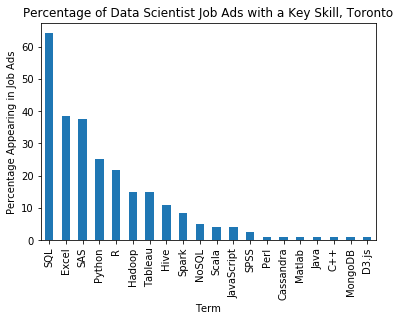

In [17]:
seattle_info = skills_info(city = 'Toronto', state = 'ON', job_title = 'data+analyst') 

There were 103 jobs found, Mississauga
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Done with collecting the job postings!
There were 87 jobs successfully found.


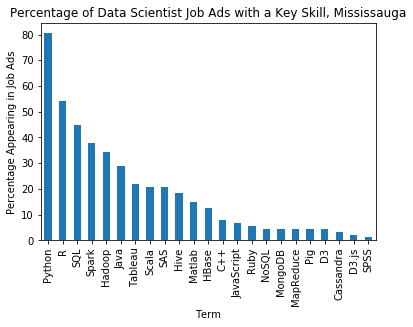

In [13]:
seattle_info = skills_info(city = 'Mississauga', state = 'ON', job_title = 'Data+Scientist') 

### Lab-2 Web Scraping Job Postings from Indeed

https://medium.com/@msalmon00/web-scraping-job-postings-from-indeed-96bd588dcb4b

In [17]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import time

In [23]:
URL = "https://ca.indeed.com/jobs?q=Data+Scientist&l=Toronto,+ON"
#conducting a request of the stated URL above:
page = requests.get(URL)
#specifying a desired format of “page” using the html parser - this allows python to read the various components of the page, rather than treating it as one long string.
soup = BeautifulSoup(page.text, "html.parser")
#printing soup in a more structured tree format that makes for easier reading
print(soup.prettify())

<!DOCTYPE html>
<html dir="ltr" lang="en">
 <head>
  <meta content="text/html;charset=utf-8" http-equiv="content-type"/>
  <script src="/s/e542d37/en_CA.js" type="text/javascript">
  </script>
  <link href="/s/1163907/jobsearch_all.css" rel="stylesheet" type="text/css"/>
  <link href="http://ca.indeed.com/rss?q=Data+Scientist&amp;l=Toronto%2C+ON" rel="alternate" title="Data Scientist Jobs in Toronto, ON" type="application/rss+xml"/>
  <link href="/m/jobs?q=Data+Scientist&amp;l=Toronto%2C+ON" media="only screen and (max-width: 640px)" rel="alternate"/>
  <link href="/m/jobs?q=Data+Scientist&amp;l=Toronto%2C+ON" media="handheld" rel="alternate"/>
  <script type="text/javascript">
   if (typeof window['closureReadyCallbacks'] == 'undefined') {
        window['closureReadyCallbacks'] = [];
    }

    function call_when_jsall_loaded(cb) {
        if (window['closureReady']) {
            cb();
        } else {
            window['closureReadyCallbacks'].push(cb);
        }
    }
  </script>

In [24]:
def extract_job_title_from_result(soup): 
    jobs = []
    for div in soup.find_all(name="div", attrs={"class":"row"}):
        for a in div.find_all(name="a", attrs={"data-tn-element":"jobTitle"}):
            jobs.append(a["title"])
    return(jobs)
extract_job_title_from_result(soup)

[u'Data Scientist, RBC Amplify - 2019',
 u'Data Scientist',
 u'Scientist, Zero Gravity Labs',
 u'Data Scientist',
 u'Customer Analytics, Data Scientist',
 u'Data Scientist',
 u'Data Scientist',
 u'Data Scientist',
 u'Data Scientist- Machine Learning',
 u'Women in Data & Analytics event',
 u'Data Scientist: Advanced Analytics',
 u'Data Scientist',
 u'Data Scientist',
 u'Data Scientist',
 u'Manager, Advanced Analytics (Principal Data Scientist)',
 u'Data Scientist']

In [25]:
def extract_company_from_result(soup): 
    companies = []
    for div in soup.find_all(name="div", attrs={"class":"row", "data-tn-component":"organicJob"}):
        company = div.find(name="div")
        company_2 = company.find(name="span", attrs={"class":"company"})
        companies.append(company_2.text.strip())
    return(companies)
 
extract_company_from_result(soup)

[u'BMO Financial Group',
 u'Overbond',
 u'Aimia',
 u'EllisDon Corporation',
 u'Amazon.com',
 u'TD Bank',
 u'IBM',
 u'savantis LLC',
 u'cogniframe.com',
 u'Logojoy']

In [26]:
def extract_location_from_result(soup): 
    locations = []
    spans = soup.findAll('span', attrs={'class': 'location'})
    for span in spans:
        locations.append(span.text)
    return(locations)
extract_location_from_result(soup)

[u'Toronto, ON',
 u'Toronto, ON',
 u'Toronto, ON',
 u'Mississauga, ON',
 u'Toronto, ON',
 u'Toronto, ON',
 u'Toronto, ON',
 u'Brampton, ON',
 u'Toronto, ON',
 u'Toronto, ON']

In [27]:
def extract_salary_from_result(soup): 
    salaries = []
    for div in soup.find_all(name="div", attrs={"class":"row", "data-tn-component":"organicJob"}):
        try:
            div_two = div.find(name="table")
            div_three = div_two.find(name="td", attrs={"class":"snip"})
            salaries.append(div_three.find(name="span", attrs={"class":"no-wrap"}).text)
        except:
            salaries.append("Nothing_found")
    return(salaries)

extract_salary_from_result(soup)

['Nothing_found',
 'Nothing_found',
 'Nothing_found',
 'Nothing_found',
 'Nothing_found',
 'Nothing_found',
 'Nothing_found',
 u'\n                $45 - $48 an hour',
 'Nothing_found',
 'Nothing_found']

In [28]:
def extract_summary_from_result(soup): 
    summaries = []
    spans = soup.findAll("span", attrs={"class": "summary"})
    for span in spans:
        summaries.append(span.text.strip())
    return(summaries)
extract_summary_from_result(soup)

[u'Familiarity with data cleaning, data mining, and machine learning. As a Data Scientist you will collaborate, innovate, ideate and build in a flexible, start-up...',
 u'Required Skills of the Data Scientist:. Additional responsibilities of the Data Scientist include:. As a Data Scientist at Equifax, you will be leveraging our...',
 u'Alliance Data participates in E-Verify. Data Theories, Machine Learning and Statistics concepts. Work with high dimensional and dynamic data to build...',
 u'Experience processing large data sets through big data architectures:. Pure Technologies, a Xylem brand, seeks to hire a Data Scientist who will be working on...',
 u'Ensure data quality via proactively identifying data integrity issues and/or taking appropriate actions to ensure data accuracy....',
 u'Lead data science initiatives to recommend actionable business insights using big data analytics and machine learning techniques....',
 u'The Data Scientist is responsible for the analytical design an

In [29]:
max_results_per_city = 100
city_set = ['Toronto','Vancouver','Montreal', 'Calgary', 'Edmonton', 'Ottawa']
columns = ["city", "job_title", "company_name", "location", "salary"]
sample_df = pd.DataFrame(columns = columns)

In [30]:
#scraping code:
for city in city_set:
    for start in range(0, max_results_per_city, 10):
        page = requests.get('http://ca.indeed.com/jobs?q=data+scientist+%2420%2C000&l=' + str(city) + '&start=' + str(start))
        time.sleep(1)  #ensuring at least 1 second between page grabs
        soup = BeautifulSoup(page.text, "lxml", from_encoding="utf-8")
        for div in soup.find_all(name="div", attrs={"class":"row", "data-tn-component":"organicJob"}): 
            #specifying row num for index of job posting in dataframe
            num = (len(sample_df) + 1) 
            #creating an empty list to hold the data for each posting
            job_post = [] 
            #append city name
            job_post.append(city) 
            #grabbing job title
            for a in div.find_all(name="a", attrs={"data-tn-element":"jobTitle"}):
                job_post.append(a["title"]) 
            #grabbing company name
            company = div.find(name="div")
            company_2 = company.find(name="span", attrs={"class":"company"})
            job_post.append(company_2.text.strip())
                #grabbing location name
            c = div.findAll('span', attrs={'class': 'location'}) 
            
            for span in c:
                print(span.text)
                job_post.append(span.text) 
                #grabbing summary text
#                 d = div.findAll('span', attrs={'class': 'summary'}) 
#                 for span in d:
#                     job_post.append(span.text.strip()) 
                #grabbing salary
            try:
                div_two = div.find(name="table")
                div_three = div_two.find(name="td", attrs={"class":"snip"})
                job_post.append(div_three.find(name="span", attrs={"class":"no-wrap"}).text)
            except:
                job_post.append("Nothing_found") 
                #appending list of job post info to dataframe at index num
                # sample_df.loc[num] = job_post
            print(job_post)
            sample_df = sample_df.append(pd.Series(job_post, index=columns), ignore_index=True)

        #saving sample_df as a local csv file — define your own local path to save contents 
        sample_df.to_csv("result-1.csv", encoding="utf-8")
 


/Users/alston/anaconda/lib/python2.7/site-packages/bs4/__init__.py:146: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")


Toronto, ON
['Toronto', 'Customer Analytics, Data Scientist', u'BMO Financial Group', u'Toronto, ON', 'Nothing_found']
Toronto, ON
['Toronto', 'Data Scientist', u'Overbond', u'Toronto, ON', 'Nothing_found']
Toronto, ON
['Toronto', 'Data Scientist', u'Aimia', u'Toronto, ON', 'Nothing_found']
Mississauga, ON
['Toronto', 'Data Scientist', u'EllisDon Corporation', u'Mississauga, ON', 'Nothing_found']
Toronto, ON
['Toronto', 'Women in Data & Analytics event', u'TD Bank', u'Toronto, ON', 'Nothing_found']
Toronto, ON
['Toronto', 'Data Scientist', u'Manulife', u'Toronto, ON', 'Nothing_found']
Brampton, ON
['Toronto', 'Data Scientist', u'savantis LLC', u'Brampton, ON', u'\n                $45 - $48 an hour']
Toronto, ON
['Toronto', 'Data Scientist', u'Logojoy', u'Toronto, ON', 'Nothing_found']
Toronto, ON
['Toronto', 'Data Scientist', u'cogniframe.com', u'Toronto, ON', 'Nothing_found']
Toronto, ON
['Toronto', 'Data Scientist: Advanced Analytics', u'IBM', u'Toronto, ON', 'Nothing_found']
Toronto

In [ ]:
# import packages
import bs4
from bs4 import BeautifulSoup

# get soup object
def get_soup(text):
    return BeautifulSoup(text, "lxml", from_encoding="utf-8")


# extract company
def extract_company(div): 
    company = div.find_all(name="span", attrs={"class":"company"})
    if len(company) > 0:
        for b in company:
            return (b.text.strip())
    else:
        sec_try = div.find_all(name="span", attrs={"class":"result-link-source"})
        for span in sec_try:
            return (span.text.strip())
    return 'NOT_FOUND'


# extract job salary
def extract_salary(div): 
    try:
        return (div.find('nobr').text)
    except:
        try:
            div_two = div.find(name='div', attrs={'class':'sjcl'})
            div_three = div_two.find('div')
            salaries.append(div_three.text.strip())
        except:
            return ('NOT_FOUND')
    return 'NOT_FOUND'


# extract job location
def extract_location(div):
    for span in div.findAll('span', attrs={'class': 'location'}):
        return (span.text)
    return 'NOT_FOUND'


# extract job title
def extract_job_title(div):
    for a in div.find_all(name='a', attrs={'data-tn-element':'jobTitle'}):
        return (a['title'])
    return('NOT_FOUND')


# extract jd summary
def extract_summary(div): 
    spans = div.findAll('span', attrs={'class': 'summary'})
    for span in spans:
        return (span.text.strip())
    return 'NOT_FOUND'
 

# extract link of job description 
def extract_link(div): 
    for a in div.find_all(name='a', attrs={'data-tn-element':'jobTitle'}):
        return (a['href'])
    return('NOT_FOUND')


# extract date of job when it was posted
def extract_date(div):
    try:
        spans = div.findAll('span', attrs={'class': 'date'})
        for span in spans:
            return (span.text.strip())
    except:
        return 'NOT_FOUND'
    return 'NOT_FOUND'


# extract full job description from link
def extract_fulltext(url):
    try:
        page = requests.get('http://www.indeed.com' + url)
        soup = BeautifulSoup(page.text, "lxml", from_encoding="utf-8")
        spans = soup.findAll('span', attrs={'class': 'summary'})
        for span in spans:
            return (span.text.strip())
    except:
        return 'NOT_FOUND'
    return 'NOT_FOUND'


# write logs to file
def write_logs(text):
    # print(text + '\n')
    f = open('log.txt','a')
    f.write(text + '\n')  
    f.close()